### Data Analyse

In [1]:
import sys
sys.path.insert(0, '/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/')
from backend.ml_pipe.data.database.mongodb import MongoDb
from backend.ml_pipe.models.xgboost.model import XGBoostModel

import pandas as pd

In [2]:
# MongoDB-Client
mongo_client = MongoDb()
result = mongo_client.get_all('classification_dataset')
raw_data = result.get('data', [])


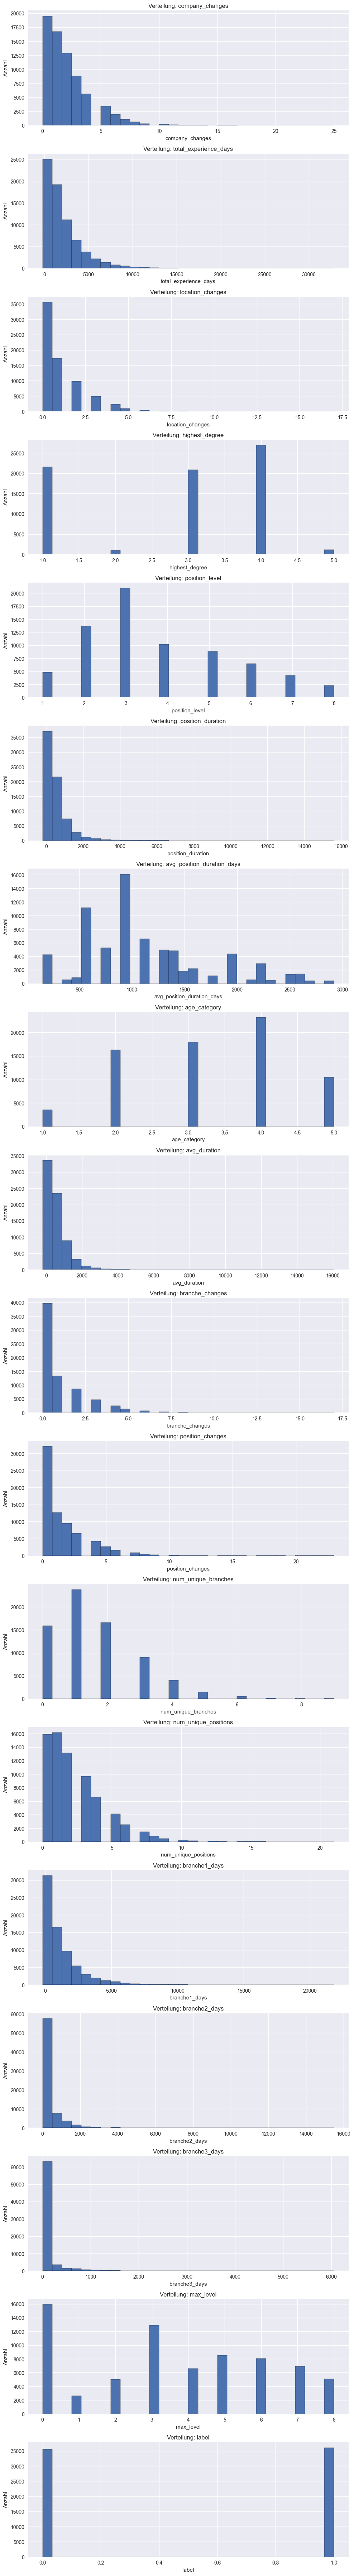

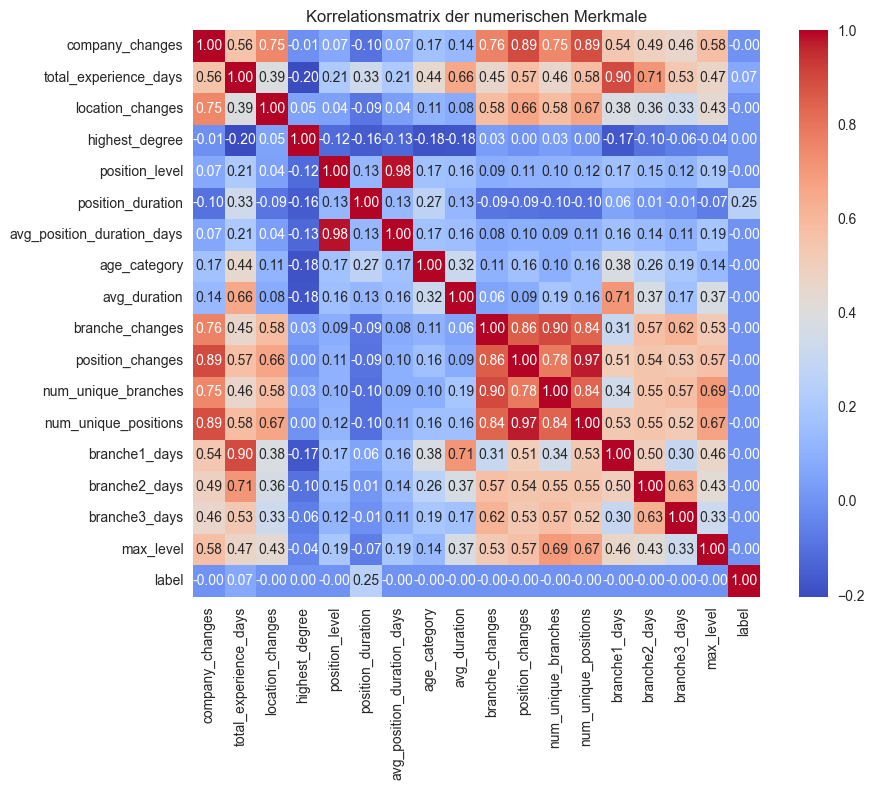

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from collections import defaultdict

# --- Mappings laden (wie im Training) ---
with open("/Users/florianrunkel/Documents/02_Uni/04_Masterarbeit/masterthesis/backend/ml_pipe/models/xgboost/saved_models/position_categories.pkl", "rb") as f:
    position_categories = pickle.load(f)
position_mapping = {name: idx for idx, name in enumerate(position_categories, 1)}

branche_levels = {
    "bau": 1, "consulting": 2, "customerservice": 3, "design": 4, "education": 5,
    "einkauf": 6, "engineering": 7, "finance": 8, "freelance": 9, "gesundheit": 10,
    "healthcare": 11, "hr": 12, "immobilien": 13, "it": 14, "legal": 15, "logistik": 16,
    "marketing": 17, "medien": 18, "operations": 19, "produktion": 20, "projektmanagement": 21,
    "research": 22, "sales": 23, "verwaltung": 24
}

# --- Feature-Extraktion wie im Training ---
def extract_career_history_features(career_history, branche_levels, position_mapping):
    durations = [pos.get("duration", 0) for pos in career_history.values()]
    avg_duration = sum(durations) / len(durations) if durations else 0

    branches = [pos.get("branche", "") for pos in career_history.values()]
    branche_changes = sum(1 for i in range(1, len(branches)) if branches[i] != branches[i-1])
    num_unique_branches = len(set(branches))

    positions = [pos.get("position", "") for pos in career_history.values()]
    position_changes = sum(1 for i in range(1, len(positions)) if positions[i] != positions[i-1])
    num_unique_positions = len(set(positions))

    branche_days = defaultdict(int)
    for pos in career_history.values():
        branche_days[pos.get("branche", "")] += pos.get("duration", 0)
    top_branche_days = sorted(branche_days.items(), key=lambda x: x[1], reverse=True)[:3]
    branche1_days = top_branche_days[0][1] if len(top_branche_days) > 0 else 0
    branche2_days = top_branche_days[1][1] if len(top_branche_days) > 1 else 0
    branche3_days = top_branche_days[2][1] if len(top_branche_days) > 2 else 0

    max_level = max([pos.get("level", 0) for pos in career_history.values()] or [0])

    return [
        avg_duration,
        branche_changes,
        position_changes,
        num_unique_branches,
        num_unique_positions,
        branche1_days,
        branche2_days,
        branche3_days,
        max_level
    ]

# --- DataFrame bauen ---
flattened = []
for entry in raw_data:
    flat = entry["features"].copy()
    # Karrierehistorie-Features extrahieren und anhängen
    career_history = flat.get("career_history", {})
    career_feats = extract_career_history_features(career_history, branche_levels, position_mapping)
    # Feature-Namen für die Karrierehistorie
    career_feature_names = [
        "avg_duration", "branche_changes", "position_changes", "num_unique_branches", "num_unique_positions",
        "branche1_days", "branche2_days", "branche3_days", "max_level"
    ]
    for name, value in zip(career_feature_names, career_feats):
        flat[name] = value
    flat["label"] = entry.get("label", None)
    flattened.append(flat)

df = pd.DataFrame(flattened)

# --- Analyse wie gehabt ---
numerische_spalten = df.select_dtypes(include=['number']).columns.tolist()

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(nrows=len(numerische_spalten), figsize=(10, 4 * len(numerische_spalten)))
if len(numerische_spalten) == 1:
    axes = [axes]

for ax, col in zip(axes, numerische_spalten):
    ax.hist(df[col].dropna(), bins=30, edgecolor='black')
    ax.set_title(f"Verteilung: {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Anzahl")
    ax.grid(True)

plt.tight_layout()
plt.show()

correlation_matrix = df[numerische_spalten].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Korrelationsmatrix der numerischen Merkmale")
plt.tight_layout()
plt.show()

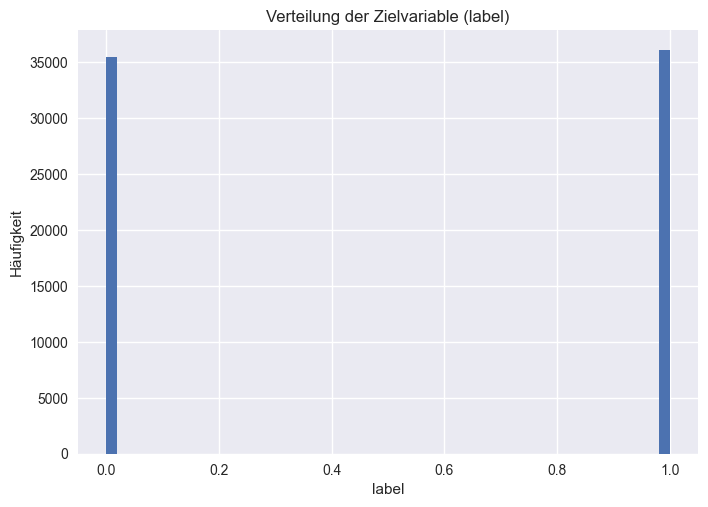

In [4]:
plt.hist(df["label"], bins=50)
plt.title("Verteilung der Zielvariable (label)")
plt.xlabel("label")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()